2020-01-19 19:21:32,562 - WARNING - tvb.simulator.common - psutil module not available: no warnings will be issued when a
    simulation may require more memory than available
   INFO  log level set to INFO
   INFO  Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
   INFO  NumExpr defaulting to 8 threads.


D:\Software\Anaconda3\envs\tvb-python3\lib\site-packages\tvb\datatypes\surfaces.py:61: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.epileptor.Epileptor.state_variable_range = Final(field_type=<class 'dict'>, default={'x1': array([-2.,  1.]), 'y1': array([-20.,   2.]), 'z': array([2., 5.]), 'x2': array([-2.,  0.]), 'y2': array([0., 2.]), 'g': array([-1.,  1.])}, required=True)
WARNING  default contains values out of the declared domain. Ex 1.0 
   attribute  tvb.simulator.models.epileptor.Epileptor2D.tt = NArray(label='tt', dtype=float64, default=array([1.]), dim_names=(), ndim=None, required=True)
WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.epileptor.Epileptor2D.state_variable_range = Final(field_type=<class 'dict'>, default={'x1': array([-2.,  1.]), 'z': array([2., 5.])}, required=True)
WARNING  default contains values out of the declared domain. Ex 1.0 
   attribute  tvb.simulator.models.epileptor

WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.stefanescu_jirsa.ReducedSetFitzHughNagumo.state_variable_range = Final(field_type=<class 'dict'>, default={'xi': array([-4.,  4.]), 'eta': array([-3.,  3.]), 'alpha': array([-4.,  4.]), 'beta': array([-3.,  3.])}, required=True)
WARNING  default contains values out of the declared domain. Ex 1.0 
   attribute  tvb.simulator.models.stefanescu_jirsa.ReducedSetHindmarshRose.a = NArray(label=':math:`a`', dtype=float64, default=array([1.]), dim_names=(), ndim=None, required=True)
WARNING  default contains values out of the declared domain. Ex 3.0 
   attribute  tvb.simulator.models.stefanescu_jirsa.ReducedSetHindmarshRose.b = NArray(label=':math:`b`', dtype=float64, default=array([3.]), dim_names=(), ndim=None, required=True)
WARNING  default contains values out of the declared domain. Ex 1.0 
   attribute  tvb.simulator.models.stefanescu_jirsa.ReducedSetHindma

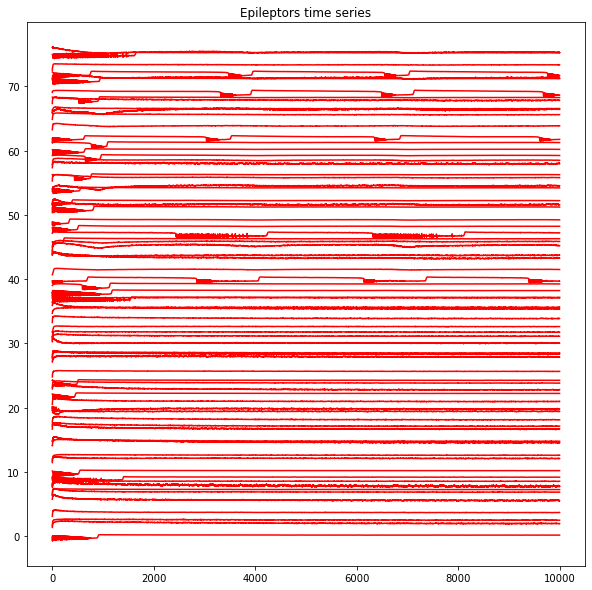

Creating RawArray with float64 data, n_channels=65, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Overwriting existing file.
Writing D:\JHU\Sri_Lab\eeg_sim.fif


<ipython-input-1-a906b3a58289>:58: RuntimeWarning: This filename (D:\JHU\Sri_Lab\eeg_sim.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw.save('eeg_sim.fif', overwrite=True)


Closing D:\JHU\Sri_Lab\eeg_sim.fif [done]


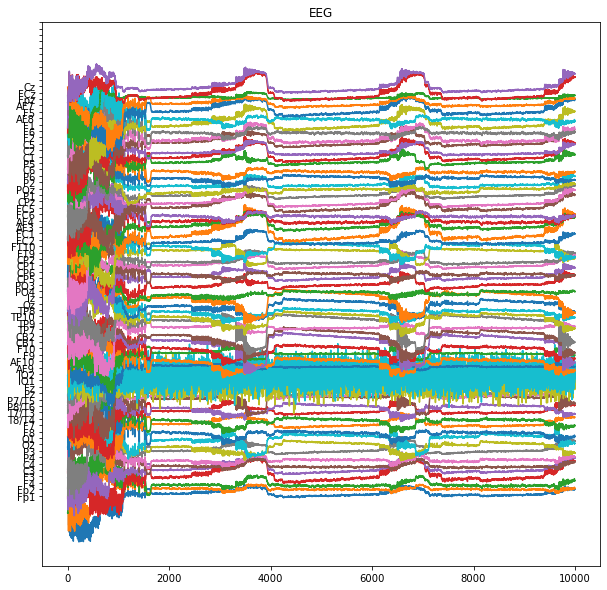

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tvb.simulator.lab import *
import mne

epileptors = models.Epileptor(Ks=np.array([-0.2]), Kf=np.array([0.1]), r=np.array([0.00015]))
epileptors.x0 = np.ones((76))*-2.4
# Setting epileptogenic regions
epileptors.x0[[62, 47, 40]] = np.ones((3))*-1.6
epileptors.x0[[69, 72]] = np.ones((2))*-1.8

con = connectivity.Connectivity.from_file()
coupl = coupling.Difference(a=np.array([1.]))

hiss = noise.Additive(nsig = np.array([0., 0., 0., 0.0003, 0.0003, 0.]))
heunint = integrators.HeunStochastic(dt=0.05, noise=hiss)

# load the default region mapping
rm = region_mapping.RegionMapping.from_file()

#Initialise some Monitors with period in physical time
mon_tavg = monitors.TemporalAverage(period=1.)
mon_EEG = monitors.EEG.from_file()
mon_EEG.region_mapping=rm
mon_EEG.period=1.

what_to_watch = (mon_tavg, mon_EEG)

#Initialise a Simulator -- Model, Connectivity, Integrator, and Monitors.
sim = simulator.Simulator(model=epileptors, connectivity=con,
                          coupling=coupl,
                          integrator=heunint, monitors=what_to_watch)

sim.configure()

(ttavg, tavg), (teeg, eeg) = sim.run(simulation_length=10000)

# Normalize the time series to have nice plots
tavg /= (np.max(tavg,0) - np.min(tavg,0 ))
eeg /= (np.max(eeg,0) - np.min(eeg,0 ))
eeg -= np.mean(eeg, 0)

#Plot raw time series
plt.figure(figsize=(10,10))
plt.plot(ttavg[:], tavg[:, 0, :, 0] + np.r_[:76], 'r')
plt.title("Epileptors time series")
plt.show()

plt.figure(figsize=(10,10))
plt.plot(teeg[:], 10*eeg[:, 0, :, 0] + np.r_[:65])
plt.yticks(np.r_[:75], mon_EEG.sensors.labels[:65])
plt.title("EEG")

# Create and save mne object
data = eeg[:, 0, :, 0].T
info = mne.create_info(ch_names=list(mon_EEG.sensors.labels[:65]), sfreq=1000, ch_types='eeg')
raw = mne.io.RawArray(data, info)
raw.save('eeg_sim.fif', overwrite=True)

Opening raw data file eeg_sim.fif...
Isotrak not found
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.


<ipython-input-3-9458f0b984f4>:2: RuntimeWarning: This filename (eeg_sim.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw = mne.io.read_raw_fif('eeg_sim.fif')


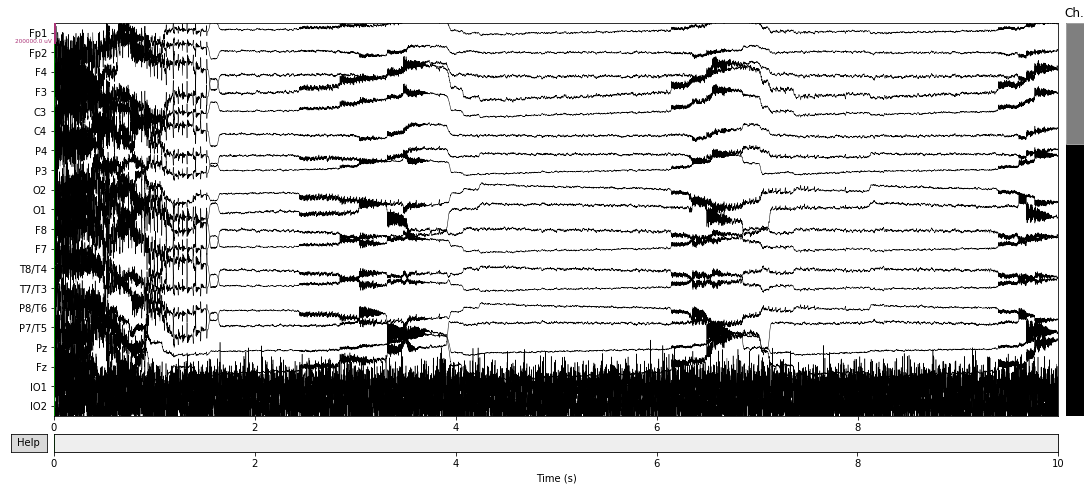

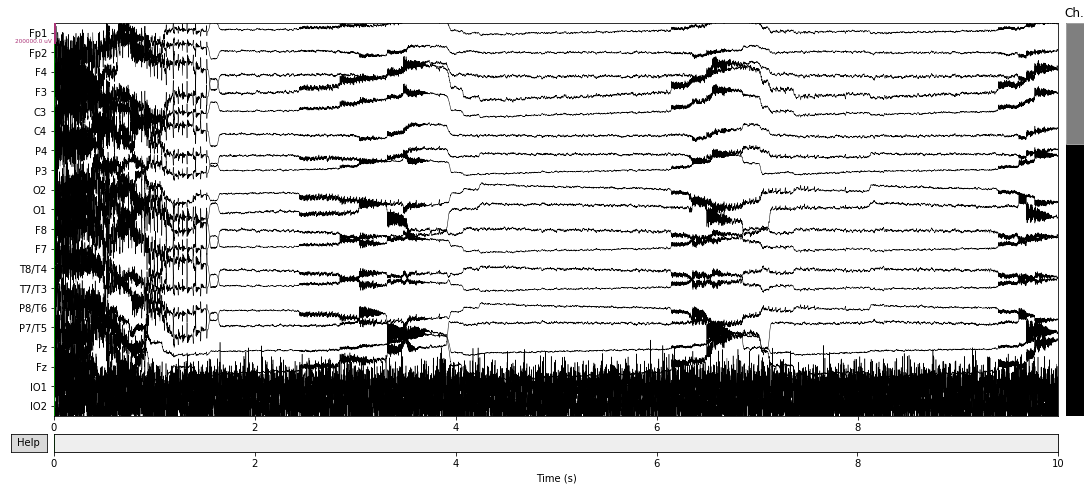

In [3]:
# load and visualize EEG file
raw = mne.io.read_raw_fif('eeg_sim.fif')
raw.plot(scalings=1e-1)